In [1]:
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 1.8.0
Eager execution: True


In [2]:
import copy as copy

In [3]:
#train_dataset_url = "C:\\Users\\andre\\.keras\\datasets\\titanic\\train_rework_train.csv"

train_dataset_fp = "C:\\Users\\andre\\.keras\\datasets\\titanic\\train_rework_train.csv"

print("Local copy of the dataset file: {}".format(train_dataset_fp))


Local copy of the dataset file: C:\Users\andre\.keras\datasets\titanic\train_rework_train.csv


In [4]:
def parse_csv(line):
  example_defaults = [[0.], [0.], [0.], [0.], [0.], [0.], [0.], [0]]  # sets field types
  parsed_line = tf.decode_csv(line, example_defaults)
  # First 7 fields are features, combine into single tensor
  features = tf.reshape(parsed_line[:-1], shape=(7,))
  # Last field is the label
  label = tf.reshape(parsed_line[-1], shape=())
  return features, label

def parse_csv_no_label(line):
  example_defaults = [[0.], [0.], [0.], [0.], [0.], [0.], [0.]]  # sets field types
  parsed_line = tf.decode_csv(line, example_defaults)
  # First 7 fields are features, combine into single tensor
  features = tf.reshape(parsed_line[:-1], shape=(7,))
  return features, label

In [5]:
train_dataset = tf.data.TextLineDataset(train_dataset_fp)
train_dataset = train_dataset.skip(1)             # skip the first header row
train_dataset = train_dataset.map(parse_csv)      # parse each row
train_dataset = train_dataset.shuffle(buffer_size=1000)  # randomize
train_dataset = train_dataset.batch(10)

In [6]:
# View a single example entry from a batch
features, label = iter(train_dataset).next()
print("example features:", features[0])
print("example label:", label[0])


example features: tf.Tensor([ 3.      0.      0.      1.      1.     15.2458  1.    ], shape=(7,), dtype=float32)
example label: tf.Tensor(1, shape=(), dtype=int32)


In [7]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(50, activation="relu", input_shape=(7,)),  # input shape required
  tf.keras.layers.Dense(50, activation="relu"),
  tf.keras.layers.Dense(50, activation="relu"),
  tf.keras.layers.Dense(2)
])


In [8]:
def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return tape.gradient(loss_value, model.variables)

In [9]:
## Note: Rerunning this cell uses the same model variables

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

best_loss = 999

In [48]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate= 0.00005)

In [49]:
num_epochs = 1001

In [50]:
for epoch in range(num_epochs):
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()
  # Training loop - using batches of 32
    for x, y in train_dataset:
    # Optimize the model
        grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.variables),
                              global_step=tf.train.get_or_create_global_step())

        # Track progress
        epoch_loss_avg(loss(model, x, y))  # add current batch loss
        # compare predicted label to actual label
        epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)
        #print(tf.argmax(model(x), axis=1, output_type=tf.int32))
  # end epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    if epoch % 10 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))
        
# copy and store best model 
    if epoch_loss_avg.result() < best_loss:
        best_loss = copy.deepcopy(epoch_loss_avg.result())
#        model_best = copy.deepcopy(model)
        print(epoch_loss_avg.result())
        print(epoch_accuracy.result())
    if epoch_loss_avg.result() < 0.42:
        break

Epoch 000: Loss: 0.465, Accuracy: 79.571%
Epoch 010: Loss: 0.463, Accuracy: 79.571%
Epoch 020: Loss: 0.457, Accuracy: 79.445%
Epoch 030: Loss: 0.459, Accuracy: 79.319%
Epoch 040: Loss: 0.455, Accuracy: 79.950%
Epoch 050: Loss: 0.455, Accuracy: 80.076%
Epoch 060: Loss: 0.451, Accuracy: 79.950%
Epoch 070: Loss: 0.454, Accuracy: 79.697%
Epoch 080: Loss: 0.453, Accuracy: 79.950%
Epoch 090: Loss: 0.452, Accuracy: 80.202%
Epoch 100: Loss: 0.454, Accuracy: 80.076%
Epoch 110: Loss: 0.456, Accuracy: 80.076%
Epoch 120: Loss: 0.451, Accuracy: 80.580%
Epoch 130: Loss: 0.451, Accuracy: 80.202%
Epoch 140: Loss: 0.452, Accuracy: 79.950%
Epoch 150: Loss: 0.450, Accuracy: 80.202%
Epoch 160: Loss: 0.464, Accuracy: 80.076%
Epoch 170: Loss: 0.459, Accuracy: 80.454%
Epoch 180: Loss: 0.458, Accuracy: 80.202%
Epoch 190: Loss: 0.452, Accuracy: 80.328%
Epoch 200: Loss: 0.449, Accuracy: 80.454%
Epoch 210: Loss: 0.452, Accuracy: 80.202%
Epoch 220: Loss: 0.456, Accuracy: 80.328%
Epoch 230: Loss: 0.447, Accuracy: 

KeyboardInterrupt: 

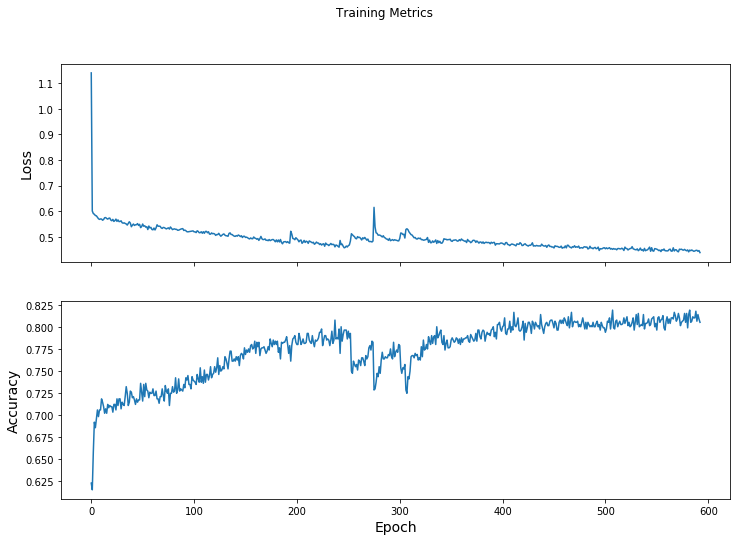

In [43]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)

plt.show()

In [28]:
#test_url = "http://download.tensorflow.org/data/iris_test.csv"

test_fp = "C:\\Users\\andre\\.keras\\datasets\\titanic\\train_rework_check.csv"

test_dataset = tf.data.TextLineDataset(test_fp)
test_dataset = test_dataset.skip(1)             # skip header row
test_dataset = test_dataset.map(parse_csv)      # parse each row with the funcition created earlier
#test_dataset = test_dataset.shuffle(1000)       # randomize
test_dataset = test_dataset.batch(50)           # use the same batch size as the training set

test_fp = "C:\\Users\\andre\\.keras\\datasets\\titanic\\train_rework_check_wierd.csv"

test_dataset2 = tf.data.TextLineDataset(test_fp)
test_dataset2 = test_dataset2.skip(1)             # skip header row
test_dataset2 = test_dataset2.map(parse_csv)      # parse each row with the funcition created earlier
#test_dataset = test_dataset.shuffle(1000)       # randomize
test_dataset2 = test_dataset2.batch(50)           # use the same batch size as the training set

In [44]:
test_accuracy1 = tfe.metrics.Accuracy()

for (x, y) in test_dataset:
    prediction1 = tf.argmax(model(x), axis=1, output_type=tf.int32)
    print(prediction1)
    print(y)
    test_accuracy1(prediction1, y)

print("Test set accuracy: {:.3%}".format(test_accuracy1.result()))

test_accuracy2 = tfe.metrics.Accuracy()

for (x, y) in test_dataset2:
    prediction2 = tf.argmax(model(x), axis=1, output_type=tf.int32)
    print(prediction2)
    print(y)
    test_accuracy2(prediction2, y)

print("Test set accuracy: {:.3%}".format(test_accuracy2.result()))

tf.Tensor(
[1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0
 0 0 1 0 0 0 0 0 1 0 0 0], shape=(49,), dtype=int32)
tf.Tensor(
[0 1 0 1 1 1 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0
 0 0 0 0 0 0 0 1 1 1 0 0], shape=(49,), dtype=int32)
Test set accuracy: 67.347%
tf.Tensor(
[1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 0
 1 1 1 1 1 0 0 0 0 1 1 1], shape=(49,), dtype=int32)
tf.Tensor(
[1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 0], shape=(49,), dtype=int32)
Test set accuracy: 61.224%


In [ ]:
predict_dataset

In [ ]:
predict_dataset2

In [40]:
predict_dataset2 = tf.convert_to_tensor([
    [3,0,34.5,0,0,7.8292,3,],
    [3,1,47,1,0,7,2,],
    [2,0,62,0,0,9.6875,3,],
    [3,0,27,0,0,8.6625,2,],
    [3,1,22,1,1,12.2875,2,],
    [3,0,14,0,0,9225,2,],
    [3,1,30,0,0,7.6292,3,],
    [2,0,26,1,1,29,2,],
    [3,1,18,0,0,7.2292,1,],
    [3,0,21,2,0,24.15,2,],
    [3,0,0,0,0,7.8958,2,],
    [1,0,46,0,0,26,2,],
    [1,1,23,1,0,82.2667,2,],
    [2,0,63,1,0,26,2,],
    [1,1,47,1,0,61175,2,],
    [2,1,24,1,0,27.7208,1,],
    [2,0,35,0,0,12.35,3,],
    [3,0,21,0,0,7225,1,],
    [3,1,27,1,0,7925,2,],
    [3,1,45,0,0,7225,1,],
    [1,0,55,1,0,59.4,1,],
    [3,0,9,0,1,3.1708,2,],
    [1,1,0,0,0,31.6833,2,],
    [1,0,21,0,1,61.3792,1,],
    [1,1,48,1,3,262375,1,],
    [3,0,50,1,0,14.5,2,],
    [1,1,22,0,1,61.9792,1,],
    [3,0,22.5,0,0,7225,1,],
    [1,0,41,0,0,30.5,2,],
    [3,0,0,2,0,21.6792,1,],
    [2,0,50,1,0,26,2,],
    [2,0,24,2,0,31.5,2,],
    [3,1,33,1,2,20575,2,],
    [3,1,0,1,2,23.45,2,],
    [1,0,30,1,0,57.75,1,],
    [3,0,18.5,0,0,7.2292,1,],
    [3,1,0,0,0,8.05,2,],
    [3,1,21,0,0,8.6625,2,],
    [3,0,25,0,0,9.5,2,],
    [3,0,0,0,0,56.4958,2,],
    [3,0,39,0,1,13.4167,1,],
    [1,0,0,0,0,26.55,2,],
    [3,0,41,0,0,7.85,2,],
    [2,1,30,0,0,13,2,],
    [1,1,45,1,0,52.5542,2,],
    [3,0,25,0,0,7925,2,],
    [1,0,45,0,0,29.7,1,],
    [3,0,0,0,0,7.75,3,],
    [1,1,60,0,0,76.2917,1,],
    [3,1,36,0,2,15.9,2,],
    [1,0,24,1,0,60,2,],
    [2,0,27,0,0,15.0333,1,],
    [2,1,20,2,1,23,2,],
    [1,1,28,3,2,263,2,],
    [2,0,0,0,0,15.5792,1,],
    [3,0,10,4,1,29125,3,],
    [3,0,35,0,0,7.8958,2,],
    [3,0,25,0,0,7.65,2,],
    [3,0,0,1,0,16.1,2,],
    [1,1,36,0,0,262375,1,],
    [3,0,17,0,0,7.8958,2,],
    [2,0,32,0,0,13.5,2,],
    [3,0,18,0,0,7.75,2,],
    [3,1,22,0,0,7725,3,],
    [1,0,13,2,2,262375,1,],
    [2,1,0,0,0,21,2,],
    [3,1,18,0,0,7.8792,3,],
    [1,0,47,0,0,42.4,2,],
    [1,0,31,0,0,28.5375,1,],
    [1,1,60,1,4,263,2,],
    [3,1,24,0,0,7.75,3,],
    [3,0,21,0,0,7.8958,2,],
    [3,1,29,0,0,7925,2,],
    [1,0,28.5,0,0,27.7208,1,],
    [1,1,35,0,0,211.5,1,],
    [1,0,32.5,0,0,211.5,1,],
    [3,0,0,0,0,8.05,2,],
    [1,1,55,2,0,25.7,2,],
    [2,0,30,0,0,13,2,],
    [3,1,24,0,0,7.75,3,],
    [3,0,6,1,1,15.2458,1,],
    [1,0,67,1,0,221.7792,2,],
    [1,0,49,0,0,26,2,],
    [3,0,0,0,0,7.8958,2,],
    [2,0,0,0,0,10.7083,3,],
    [3,0,0,1,0,14.4542,1,],
    [3,1,27,0,0,7.8792,3,],
    [3,1,18,0,0,8.05,2,],
    [3,1,0,0,0,7.75,3,],
    [2,0,2,1,1,23,2,],
    [3,1,22,1,0,13.9,2,],
    [3,0,0,0,0,7775,2,],
    [1,1,27,1,2,52,2,],
    [3,0,0,0,0,8.05,2,],
    [1,0,25,0,0,26,1,],
    [3,0,25,0,0,7.7958,2,],
    [1,1,76,1,0,78.85,2,],
    [3,0,29,0,0,7925,2,],
    [3,1,20,0,0,7.8542,2,],
    [3,0,33,0,0,8.05,2,],
    [1,1,43,1,0,55.4417,1,],
    [2,0,27,1,0,26,2,],
    [3,0,0,0,0,7.75,3,],
    [3,0,26,0,0,7775,2,],
    [3,1,16,1,1,8.5167,1,],
    [3,0,28,0,0,22525,2,],
    [3,0,21,0,0,7.8208,3,],
    [3,0,0,0,0,7.75,3,],
    [3,0,0,0,0,8.7125,2,],
    [2,0,18.5,0,0,13,2,],
    [2,0,41,0,0,15.0458,1,],
    [3,1,0,0,0,7.7792,3,],
    [1,1,36,0,0,31.6792,1,],
    [3,1,18.5,0,0,7.2833,3,],
    [1,1,63,1,0,221.7792,2,],
    [3,0,18,1,0,14.4542,1,],
    [3,0,0,0,0,6.4375,1,],
    [3,1,1,1,1,16.7,2,],
    [1,0,36,0,0,75.2417,1,],
    [2,1,29,1,0,26,2,],
    [2,1,12,0,0,15.75,2,],
    [3,0,0,1,0,7.75,3,],
    [1,1,35,1,0,57.75,1,],
    [3,0,28,0,0,7.25,2,],
    [3,0,0,0,0,7.75,3,],
    [3,1,17,0,1,16.1,2,],
    [3,0,22,0,0,7.7958,2,],
    [3,1,0,2,0,23.25,3,],
    [2,0,42,0,0,13,2,],
    [3,0,24,0,0,8.05,2,],
    [3,0,32,0,0,8.05,2,],
    [1,0,53,0,0,28.5,1,],
    [3,1,0,0,4,25.4667,2,],
    [3,0,0,1,0,6.4375,1,],
    [3,0,43,0,0,7.8958,2,],
    [3,0,24,0,0,7.8542,2,],
    [3,0,26.5,0,0,7225,1,],
    [2,0,26,0,0,13,2,],
    [3,1,23,0,0,8.05,2,],
    [3,0,40,1,6,46.9,2,],
    [3,1,10,5,2,46.9,2,],
    [1,1,33,0,0,151.55,2,],
    [1,0,61,1,3,262375,1,],
    [2,0,28,0,0,26,2,],
    [1,0,42,0,0,26.55,2,],
    [3,0,31,3,0,18,2,],
    [1,0,0,0,0,51.8625,2,],
    [3,0,22,0,0,8.05,2,],
    [1,0,0,0,0,26.55,2,],
    [2,0,30,1,1,26,2,],
    [1,1,23,0,1,83.1583,1,],
    [3,0,0,0,0,7.8958,1,],
    [3,0,60.5,0,0,0,2,],
    [3,1,36,0,2,12.1833,2,],
    [3,0,13,4,2,31.3875,2,],
    [3,0,24,0,0,7.55,2,],
    [1,1,29,0,0,221.7792,2,],
    [3,1,23,0,0,7.8542,2,],
    [1,0,42,0,0,26.55,2,],
    [3,1,26,0,2,13775,2,],
    [3,1,0,0,0,7.7333,3,],
    [3,0,7,1,1,15.2458,1,],
    [2,1,26,0,0,13.5,2,],
    [3,0,0,0,0,7,2,],
    [2,0,41,0,0,13,2,],
    [3,1,26,1,1,22025,2,],
    [1,0,48,0,0,50.4958,1,],
    [3,0,18,2,2,34375,2,],
    [1,1,0,0,0,27.7208,1,],
    [3,1,22,0,0,8.9625,2,],
    [3,0,0,0,0,7.55,2,],
    [3,0,27,0,0,7225,1,],
    [3,0,23,1,0,13.9,2,],
    [3,0,0,0,0,7.2292,1,],
    [3,0,40,1,5,31.3875,2,],
    [2,1,15,0,2,39,2,],
    [2,1,20,0,0,36.75,2,],
    [1,0,54,1,0,55.4417,1,],
    [2,1,36,0,3,39,2,],
    [1,1,64,0,2,83.1583,1,],
    [2,0,30,0,0,13,2,],
    [1,0,37,1,1,83.1583,1,],
    [1,1,18,1,0,53.1,2,],
    [3,0,0,0,0,7.75,3,],
    [1,1,27,1,1,247.5208,1,],
    [2,0,40,0,0,16,2,],
    [2,1,21,0,1,21,2,],
    [3,0,17,2,0,8.05,2,],
    [3,1,0,8,2,69.55,2,],
    [2,0,40,0,0,13,2,],
    [2,0,34,1,0,26,2,],
    [1,0,0,0,0,26,2,],
    [3,0,11.5,1,1,14.5,2,],
    [2,0,61,0,0,12.35,3,],
    [2,0,8,0,2,32.5,2,],
    [3,0,33,0,0,7.8542,2,],
    [1,0,6,0,2,134.5,1,],
    [3,1,18,0,0,7775,2,],
    [2,0,23,0,0,10.5,2,],
    [3,1,0,0,0,8.1125,2,],
    [3,1,0,0,0,15.5,3,],
    [3,0,0.33,0,2,14.4,2,],
    [1,0,47,1,0,227525,1,],
    [2,1,8,1,1,26,2,],
    [2,0,25,0,0,10.5,2,],
    [1,0,0,0,0,25.7417,1,],
    [3,1,35,0,0,7.75,3,],
    [2,0,24,0,0,10.5,2,],
    [1,1,33,0,0,27.7208,1,],
    [3,0,25,0,0,7.8958,2,],
    [3,0,32,0,0,22525,2,],
    [3,0,0,0,0,7.05,2,],
    [2,0,17,0,0,73.5,2,],
    [2,1,60,1,0,26,2,],
    [3,1,38,4,2,7775,2,],
    [1,0,42,0,0,42.5,2,],
    [3,1,0,0,0,7.8792,3,],
    [1,0,57,1,1,164.8667,2,],
    [1,1,50,1,1,211.5,1,],
    [3,0,0,0,0,8.05,2,],
    [2,1,30,1,0,13.8583,1,],
    [3,0,21,0,0,8.05,2,],
    [2,1,22,0,0,10.5,2,],
    [3,0,21,0,0,7.7958,2,],
    [1,1,53,0,0,27.4458,1,],
    [3,1,0,0,2,15.2458,1,],
    [3,0,23,0,0,7.7958,2,],
    [3,1,0,0,0,7.75,3,],
    [3,0,40.5,0,0,15.1,2,],
    [2,0,36,0,0,13,2,],
    [2,0,14,0,0,65,2,],
    [1,1,21,0,0,26.55,2,],
    [3,0,21,1,0,6.4958,2,],
    [3,0,0,0,0,7.8792,3,],
    [1,0,39,1,0,71.2833,1,],
    [3,0,20,0,0,7.8542,2,],
    [1,0,64,1,0,75.25,1,],
    [3,0,20,0,0,7225,1,],
    [2,1,18,1,1,13,2,],
    [1,1,48,1,0,106425,1,],
    [1,1,55,0,0,27.7208,1,],
    [2,1,45,0,2,30,2,],
    [1,0,45,1,1,134.5,1,],
    [3,0,0,0,0,7.8875,2,],
    [3,0,0,1,2,23.45,2,],
    [1,0,41,1,0,51.8625,2,],
    [2,1,22,0,0,21,2,],
    [2,0,42,1,1,32.5,2,],
    [2,1,29,1,0,26,2,],
    [3,1,0,1,0,14.4542,1,],
    [2,1,0.92,1,2,27.75,2,],
    [3,0,20,0,0,7925,2,],
    [1,0,27,1,0,136.7792,1,],
    [3,0,24,0,0,9325,2,],
    [3,0,32.5,0,0,9.5,2,],
    [3,0,0,0,0,7.55,2,],
    [3,0,0,0,0,7.75,3,],
    [3,0,28,0,0,8.05,2,],
    [2,1,19,0,0,13,2,],
    [3,0,21,0,0,7775,2,],
    [3,0,36.5,1,0,17.4,2,],
    [3,0,21,0,0,7.8542,2,],
    [2,1,29,0,2,23,2,],
    [3,1,1,1,1,12.1833,2,],
    [2,0,30,0,0,12.7375,1,],
    [3,0,0,0,0,7.8958,2,],
    [1,0,0,0,0,0,2,],
    [3,0,0,0,0,7.55,2,],
    [3,1,0,0,0,8.05,2,],
    [3,0,17,0,0,8.6625,2,],
    [1,0,46,0,0,75.2417,1,],
    [3,0,0,0,0,7.75,3,],
    [1,1,26,1,0,136.7792,1,],
    [3,1,0,1,0,15.5,3,],
    [3,0,0,0,0,7225,1,],
    [2,1,20,1,0,26,2,],
    [2,0,28,0,0,10.5,2,],
    [2,0,40,1,0,26,2,],
    [2,0,30,1,0,21,2,],
    [2,0,22,0,0,10.5,2,],
    [3,1,23,0,0,8.6625,2,],
    [3,0,0.75,1,1,13775,2,],
    [3,1,0,0,0,7.75,3,],
    [3,1,9,1,1,15.2458,1,],
    [3,1,2,1,1,20.2125,2,],
    [3,0,36,0,0,7.25,2,],
    [3,0,0,0,0,7.25,2,],
    [1,0,24,1,0,82.2667,2,],
    [3,0,0,0,0,7.2292,1,],
    [3,0,0,0,0,8.05,2,],
    [1,0,0,0,0,39.6,2,],
    [3,1,30,0,0,6.95,3,],
    [3,0,0,0,0,7.2292,1,],
    [1,0,53,1,1,81.8583,2,],
    [3,0,36,0,0,9.5,2,],
    [3,0,26,0,0,7.8958,2,],
    [2,1,1,1,2,41.5792,1,],
    [3,0,0,2,0,21.6792,1,],
    [1,0,30,0,0,45.5,2,],
    [3,0,29,0,0,7.8542,2,],
    [3,0,32,0,0,7775,2,],
    [2,0,0,0,0,15.0458,1,],
    [2,0,43,0,1,21,2,],
    [3,0,24,0,0,8.6625,2,],
    [3,1,0,0,0,7.75,3,],
    [1,1,64,1,1,26.55,2,],
    [1,0,30,1,2,151.55,2,],
    [3,0,0.83,0,1,9.35,2,],
    [1,0,55,1,1,93.5,2,],
    [3,1,45,1,0,14.1083,2,],
    [3,0,18,0,0,8.6625,2,],
    [3,0,22,0,0,7225,1,],
    [3,0,0,0,0,7575,2,],
    [3,1,37,0,0,7.75,3,],
    [1,1,55,0,0,135.6333,1,],
    [3,1,17,0,0,7.7333,3,],
    [1,0,57,1,0,146.5208,1,],
    [2,0,19,0,0,10.5,2,],
    [3,0,27,0,0,7.8542,2,],
    [2,0,22,2,0,31.5,2,],
    [3,0,26,0,0,7775,2,],
    [3,0,25,0,0,7.2292,1,],
    [2,0,26,0,0,13,2,],
    [1,0,33,0,0,26.55,2,],
    [1,1,39,0,0,211.3375,2,],
    [3,0,23,0,0,7.05,2,],
    [2,1,12,2,1,39,2,],
    [1,0,46,0,0,79.2,1,],
    [2,0,29,1,0,26,2,],
    [2,0,21,0,0,13,2,],
    [2,1,48,0,2,36.75,2,],
    [1,0,39,0,0,29.7,1,],
    [3,0,0,0,0,7225,1,],
    [3,1,19,1,1,15.7417,1,],
    [3,0,27,0,0,7.8958,2,],
    [1,0,30,0,0,26,2,],
    [2,0,32,0,0,13,2,],
    [3,0,39,0,2,7.2292,1,],
    [2,0,25,0,0,31.5,2,],
    [3,0,0,0,0,7.2292,1,],
    [2,0,18,0,0,10.5,2,],
    [3,0,32,0,0,7.5792,2,],
    [3,0,0,1,9,69.55,2,],
    [1,1,58,0,1,512.3292,1,],
    [3,0,0,1,1,14.5,2,],
    [3,1,16,0,0,7.65,2,],
    [2,0,26,0,0,13,2,],
    [3,1,38,0,0,7.2292,1,],
    [2,0,24,0,0,13.5,2,],
    [2,1,31,0,0,21,2,],
    [1,1,45,0,1,63.3583,1,],
    [2,0,25,0,0,10.5,2,],
    [2,0,18,0,0,73.5,2,],
    [2,0,49,1,2,65,2,],
    [3,1,0.17,1,2,20575,2,],
    [1,0,50,0,0,26,2,],
    [1,1,59,2,0,51.4792,2,],
    [3,0,0,0,0,7.8792,2,],
    [3,0,0,0,0,7.75,3,],
    [3,1,30,1,0,15.55,2,],
    [3,0,14.5,8,2,69.55,2,],
    [2,1,24,1,1,37.0042,1,],
    [2,1,31,0,0,21,2,],
    [3,0,27,0,0,8.6625,2,],
    [1,1,25,1,0,55.4417,1,],
    [3,1,0,1,9,69.55,2,],
    [3,0,0,1,0,14.4583,1,],
    [3,1,22,0,0,39.6875,2,],
    [1,1,45,0,1,59.4,1,],
    [2,0,29,0,0,13.8583,1,],
    [2,0,21,1,0,11.5,2,],
    [1,1,31,0,0,134.5,1,],
    [1,0,49,0,0,0,2,],
    [2,0,44,0,0,13,2,],
    [1,1,54,1,1,81.8583,2,],
    [1,1,45,0,0,262375,1,],
    [3,1,22,2,0,8.6625,2,],
    [2,0,21,0,0,11.5,2,],
    [1,0,55,0,0,50,2,],
    [3,0,5,4,2,31.3875,2,],
    [3,0,0,0,0,7.75,3,],
    [3,0,26,0,0,7.8792,3,],
    [3,1,0,0,0,14.5,2,],
    [3,1,19,1,0,16.1,2,],
    [2,0,0,0,0,12875,2,],
    [2,1,24,1,2,65,2,],
    [3,0,24,0,0,7775,2,],
    [2,0,57,0,0,13,2,],
    [3,0,21,0,0,7.75,3,],
    [3,0,6,3,1,21075,2,],
    [1,0,23,0,0,93.5,2,],
    [1,1,51,0,1,39.4,2,],
    [3,0,13,0,2,20.25,2,],
    [2,0,47,0,0,10.5,2,],
    [3,0,29,3,1,22025,2,],
    [1,1,18,1,0,60,2,],
    [3,0,24,0,0,7.25,3,],
    [1,1,48,1,1,79.2,1,],
    [3,0,22,0,0,7775,2,],
    [3,0,31,0,0,7.7333,3,],
    [1,1,30,0,0,164.8667,2,],
    [2,0,38,1,0,21,2,],
    [1,1,22,0,1,59.4,1,],
    [1,0,17,0,0,47.1,2,],
    [1,0,43,1,0,27.7208,1,],
    [2,0,20,0,0,13.8625,1,],
    [2,0,23,1,0,10.5,2,],
    [1,0,50,1,1,211.5,1,],
    [3,1,0,0,0,7.7208,3,],
    [3,1,3,1,1,13775,2,],
    [3,1,0,0,0,7.75,3,],
    [1,1,37,1,0,90,3,],
    [3,1,28,0,0,7775,2,],
    [3,0,0,0,0,8.05,2,],
    [1,1,39,0,0,108.9,1,],
    [3,0,38.5,0,0,7.25,2,],
    [3,0,0,0,0,8.05,2,],
    [3,0,0,1,1,22.3583,1,]
])

class_ids = ["survived", "lost"]
test_fp = "C:\\Users\\andre\\.keras\\datasets\\titanic\\test_rework.csv"


In [45]:
predictions = model(predict_dataset2)

for i, logits in enumerate(predictions):
    class_idx = tf.argmax(logits).numpy()
    name = class_ids[class_idx]
    #print("Example {} prediction: {}".format(i, name)," ","id: {}".format(class_idx))
    print("{}".format(class_idx))

0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
1
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
0
1
1
0
0
0
1
0
1
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
1
0
0
0
1
1
0
1
0
1
0
1
0
0
0
0
1
1
1
0
1
0
1
0
0
0
1
0
1
0
1
0
0
0
1
0
0
0
0
0
0
1
1
1
1
0
0
0
1
1
1
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
1
0
0
0
0
0
0
0
0
1
0
0
1
0
0
1
1
0
0
1
0
1
0
0
0
0
0
0
1
0
0
0
0
0
1
1
0
1
1
0
1
1
0
1
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
1
1
0
0
1
1
1
0
1
0
1
0
1
0
0
1
0
0
1
1
0
0
1
0
1
0
1
0
1
1
1
0
0
1
1
0
1
0
0
0
1
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
1
0
1
0
0
1
0
0
0
0
1
0
1
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
1
0
1
1
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
1
1
0
1
0
0
0
1
0
0
0
0
1
1
0
1
0
0
1
1
0
0
1
0
0
1
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
1
1
0
0
0
1
0
1
0
0
1
0
1
1
0
0
0
1
1
0
1
1
0
0
1
0
0
0
